In [2]:
import numpy as np
import matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')
doplot=2
%matplotlib nbagg
import cPickle as pickle
import sys
%load_ext autoreload
%autoreload 2

/Users/jklymak/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# TTide variable stratification resonance searching

This code is based on *Dale et al 2001* (JPO) who searched for resonant conditions of partially trapped modes on a continental shelf.  The idea is that you force a shelf geometry and that resonant spatial modes will "ring" with a higher amplitude.  Here we hold the frequency of the forcing constant at the tidal frequency ($\omega = 1.4 f$) and sweep through the along-slope wavelength between 30 km and 190 km.  The observed wavelenth was found to lengthen as the continental slope became more narrow. 

Here we use an idealization of the stratification from TTide (basically an exponential profile fit to the WOA profile), and the bathymetry used in Klyamk et al 2016 (straight shelves) to find the resonant spatial modes.  We find they agree qutie well with the three-d non-linear solutions.

The solver for the reflection problem is described at https://github.com/jklymak/LindzenKuo and is based on *Lindzen and Kuo, 1968* as implimented by *Dale et al, 2001* and predecessors.

<IPython.core.display.Javascript object>


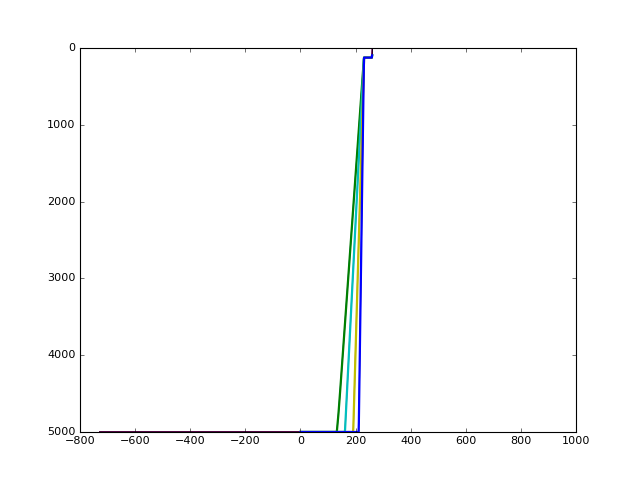

In [5]:
## Need to setup.  Load in the bathymetry.  
import matfile as mf
import hdf5storage
# get the exact shelves:
todo = ['Shelf100km','Shelf1km03','Shelf1km04','Shelf020km']
fig,ax=plt.subplots()
Hwkb=[]  # akward name from when I tried this w/ WKB stretching....

xmod=np.linspace(0.,260.,261)
for nn,td in enumerate(todo):
    D = hdf5storage.loadmat('../ttide15/Tas3d/%s/Diags0360.mat'%td)
    H = D['Depth'].transpose()[:,-1]
    x = -D['x']/1e3-30.+xmod[-1]
    ax.plot(x,H)
    #ax.set_xlim([-10.,170])
    ray=mf.loadmatbunch ('../TasmaniaRays.mat')
    ray = ray['ray']
    z=np.arange(0.,5000.,2.)
    
    N=  np.interp(z,ray['z'],np.sqrt(ray['N2']))
    N0 = np.mean(N)
    Hwkb.append(np.interp(-xmod,-x,H))
    ax.plot(xmod,Hwkb[nn],lw=2)


ax.set_ylim([5000,0])

#Hwkb = np.interp(H,z,zwkb)
z0 = np.linspace(-6500,0.,1000)
Nsq0 = np.interp(z0,-(ray['z'][2:][::-1]*1.),ray['N2'][2:][::-1])
Nsq0 = np.interp(z0,-(ray['z'][2:][::-1]*1.),np.sort(ray['N2'][2:][::-1]))


<IPython.core.display.Javascript object>


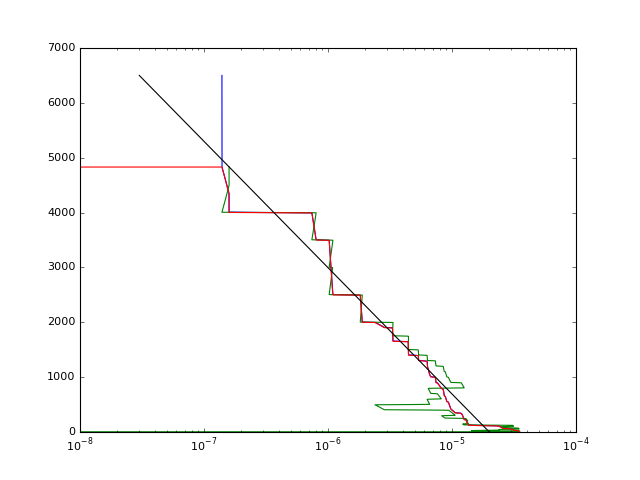

In [3]:
fig,ax=plt.subplots()
ax.plot(Nsq0,-z0)
ax.plot(ray['N2'],(1.*ray['z']))
ax.plot(-np.sort(-ray['N2']),(1.*ray['z']))
ax.plot(2e-5*np.exp(z0/1000),-z0,'k')

ax.set_xscale('log')
#ax.set_yscale('log')
Nsq0 = 2e-5*np.exp(z0/1000.)

<IPython.core.display.Javascript object>


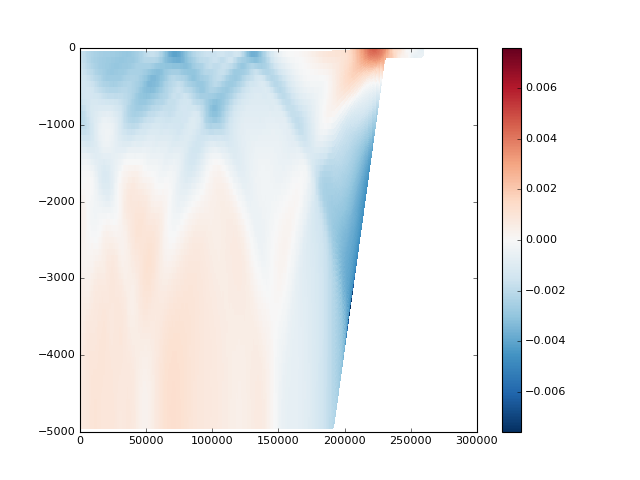

0.00760391221166
[ 5000.          5000.          5000.          5000.          5000.          5000.
  5000.          5000.          5000.          5000.          5000.          5000.
  5000.          5000.          5000.          5000.          5000.          5000.
  5000.          5000.          5000.          5000.          5000.          5000.
  5000.          5000.          5000.          5000.          5000.          5000.
  5000.          5000.          5000.          5000.          5000.          5000.
  5000.          5000.          5000.          5000.          5000.          5000.
  5000.          5000.          5000.          5000.          5000.          5000.
  5000.          5000.          5000.          5000.          5000.          5000.
  5000.          5000.          5000.          5000.          5000.          5000.
  5000.          5000.          5000.          5000.          5000.          5000.
  5000.          5000.          5000.          5000.          5000.   

In [5]:
import SolveRefl as sr
f=1e-4
omega = np.pi*2./12.4/3600.
k = np.pi*2./149e3

x,z,H,P,debug=sr.SolveRefl(k=k,Nsq0=Nsq0,z0=z0,omega=omega,f=f,wall=False,x=xmod*1e3,
                           H=Hwkb[2],J=32*2,Incoming=False)
fig,ax=plt.subplots()
pcm=ax.pcolormesh(x,z[:,np.newaxis]*H[np.newaxis,:],np.real(P),cmap='RdBu_r')
m=np.max(np.abs(pcm.get_clim())) 
print m
pcm.set_clim([-m,m])
fig.colorbar(pcm,ax=ax)
print Hwkb[2]

## Get linear response

Compicated because the peaks are not always trivial to see...

In [4]:
import SolveRefl as sr
import cPickle as pickle

lam = np.linspace(30.,180.0,300)*1e3
ks = np.pi*2./lam
#ks = np.linspace(0,1.,21)
#ks = ks[1:]*1e-4
f=1.e-4
oms = np.linspace(0.,2.,21)*f
oms=oms[1:]
oms  = [(np.pi*2./12.4/3600.)]

resp = []
for numb,hin in enumerate(np.arange(4)):
#for numb,hin in enumerate([2]):
    sys.stdout.write('%d'%numb)
    resp.append(np.zeros((len(oms),len(ks))))
    for m,omega in enumerate(oms):
        for n,k in enumerate(ks):
            sys.stdout.write('.')
            Hin=Hwkb[hin]
            try:
                x,z,H,P,debug=sr.SolveRefl(k=k,Nsq0=Nsq0,z0=z0,omega=omega,f=f,wall=True,x=xmod*1e3,
                           H=Hwkb[hin],J=64*3,Incoming=False)
                res=1.e-99
                for num,dt in enumerate(np.linspace(0.,np.pi,100)):
                    ind = np.where(x>(x[-1]-70e3))[0]
                    re=np.mean(np.abs(np.real(P[:,ind]*np.exp(1j*dt)))*H[np.newaxis,ind])
                    if re>res:
                        res=re
            except:
                print "Grr"
                res=1e-50
            resp[numb][m,n]=res
        sys.stdout.write('\r')
if 1:
    pickle.dump([resp,ks],open('ResponseNew2.pickle','wb'))
print "Done!!"
            

Done!!


<IPython.core.display.Javascript object>


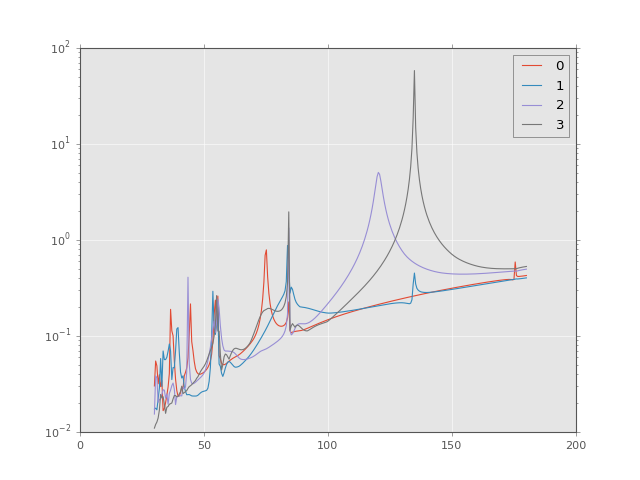

(0, 200)

In [55]:
resp,ks=pickle.load(open('ResponseNew2.pickle','rb'))
import matplotlib.style as style
style.use('ggplotjmk')

fig,axs = plt.subplots()
for a in range(4):
    resp[a][resp[a]<1e-40]=np.nan
    axs.semilogy(np.pi*2./ks/1e3,resp[a][0,:],label='%d'%a)
axs.legend()
axs.set_xlim(0,200)
#axs.set_ylim([1e10,1e15])


<IPython.core.display.Javascript object>


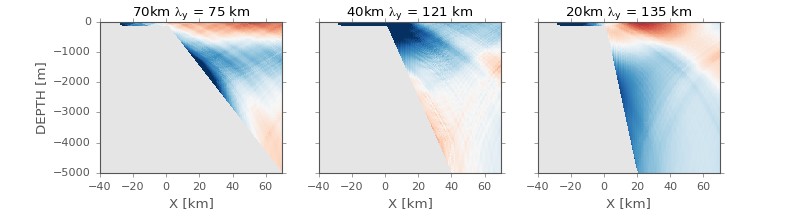

In [50]:
import SolveRefl as sr
## Plot the peaks
omega = (np.pi*2./12.4/3600.)
f = 1.e-4
def symclim(pcm):
    cl = pcm.get_clim()
    m = np.max(np.abs(cl))
    pcm.set_clim([-m,m])
peak = np.array([74.,75.16,120.80,134.85])*1e3
clims = [0,8,4.,8.]
tit = ['','70km','40km','20km' ]
fig,axs=plt.subplots(1,3,figsize=(10,2.7),sharex=True, sharey=True);axs=axs.flatten()
fig.subplots_adjust(bottom=0.2)
for a in range(1,4):
    Hin=Hwkb[a]
    k = np.pi*2./peak[a]
    #k = 0.
    x,z,H,P,debug=sr.SolveRefl(k=k,Nsq0=Nsq0,z0=z0,omega=omega,f=f,wall=True,x=xmod*1e3,
                           H=Hin,J=64*3,Incoming=False)
    #x,z,H,P,debug=sr.SolveRefl(k=k,Nsq0=Nsq0,z0=z0,omega=omega,f=f,wall=True,x=xmod*1e3,
    #                       H=Hin,J=64*3,Incoming=False,Forcing=P)
    ax=axs[a-1]
    ind = np.where(x>0.e3)[0]
    offset = np.mean(P[:,0])*0.
    pcm=ax.pcolormesh(232.-x[ind]/1e3,z[:,np.newaxis]*H[np.newaxis,:][:,ind],np.real(P[:,ind]-offset)*1e4,rasterized=True,cmap='RdBu_r')
    symclim(pcm)
    ax.set_xlim([0.,np.max(x)/1e3])
    ax.set_xlim([-40.,70.])
    pcm.set_clim(np.array([-1.,1.])*clims[a])
    ax.set_title('%s $\lambda_y$ = %1.0f km'%(tit[a],peak[a]/1e3),fontsize=12 )
    ax.set_xlabel('X [km]')
axs[0].set_ylabel('DEPTH [m]')
    #fig.colorbar(pcm,ax=ax)
if 1: 
    fig.savefig('doc/Fitmodes.pdf')

In [49]:
print offset

(-1.24155817719e-05-1.54985014859e-05j)


In [48]:
fig.savefig('doc/Fitmodes.pdf')

In [26]:
pcm.set_clim(np.array([-1,1.001])*1000000*6)
    

[ 115.42711404    +0.j           95.35602737    +0.j           44.32418375    +0.j
    0.00000000   -89.6148494j     0.00000000  -144.46433447j
    0.00000000  -191.12337446j    0.00000000  -234.47317236j
    0.00000000  -276.0194126j     0.00000000  -316.41586897j
    0.00000000  -355.99647675j    0.00000000  -394.94835028j
    0.00000000  -433.38206384j    0.00000000  -471.36452049j
    0.00000000  -508.9359126j     0.00000000  -546.11912893j
    0.00000000  -582.92526112j    0.00000000  -619.35695544j
    0.00000000  -655.41050299j    0.00000000  -691.07715027j
    0.00000000  -726.34389962j    0.00000000  -761.19395212j
    0.00000000  -795.60687714j    0.00000000  -829.55854752j
    0.00000000  -863.02084691j    0.00000000  -895.96112589j
    0.00000000  -928.34135601j    0.00000000  -960.11690529j
    0.00000000  -991.23486413j    0.00000000 -1021.63198902j
    0.00000000 -1051.23297542j    0.00000000 -1079.95207768j
    0.00000000 -1107.70775316j    0.00000000 -1134.47200962j
  

<IPython.core.display.Javascript object>


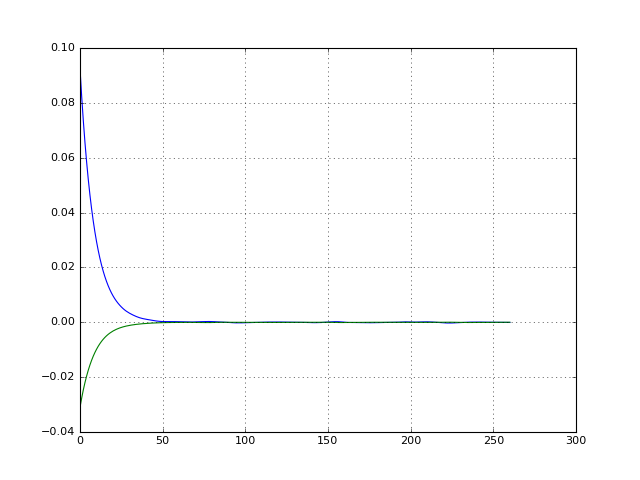

In [144]:
print debug[1]*1000.
fig,ax=plt.subplots()
ax.plot(P[-1,:]-offset)
ax.plot(P[0,:]-offset)
ax.grid('on')

In [95]:
E2 = debug[1]
E1 = debug[0]
k = debug[2]
print np.pi*2./k[0]
print np.abs(np.sum(E1[:,0]*E1[:,2]))

-170.611420872j
6.35586028253e-12


<IPython.core.display.Javascript object>


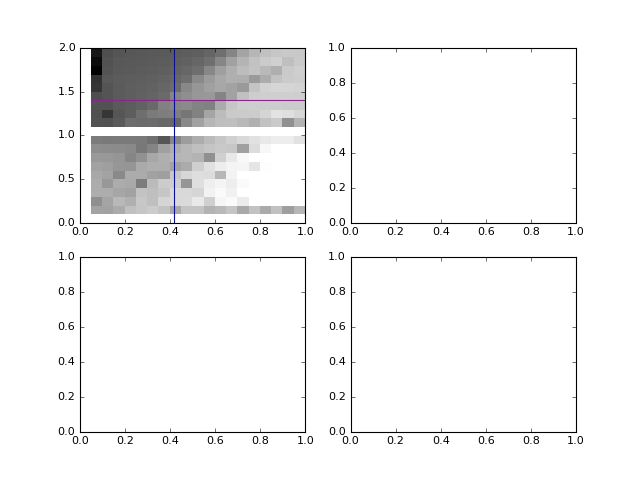

In [26]:
fig,axs = plt.subplots(2,2)
axs=axs.flatten()
xx=np.pi*2./ks/1e3
xx = ks/1e-4
k0 = np.pi*2./np.array([150.,110.,160.,220.])/1e3/1e-4
for a in [0]:
    ax=axs[a]
    pcm=ax.pcolormesh(xx,oms/f,np.log10(resp[a]),rasterized=True,cmap='gray_r')
    pcm.set_clim(0,5)
    ax.plot(xx,0.*ks+(np.pi*2./12.4/3600.)/f,'m')
    ax.plot(k0[a]*np.array([1,1]),[0.,2.])
    ax.set_xlim([0.,1.])

In [56]:

lam = np.linspace(40,180.0,140)*1e3
ks = np.pi*2./lam
kims = np.linspace(0,np.pi*2./40e3,50)
oms = np.linspace(1.,2.,50)
oms = oms[1:]
#ks=np.linspace(0.,2.,50)*1e-4
#ks = np.array([0.])
f=1.e-4
omega = np.pi*2./12.4/3600.
try:
    respold = resp
except:
    respold = ks*0.+1e-10


    
def getRes(Hin,kin,omega):
    
    #H=Hk[0]
    #k=Hk[1]
    x,z,H,P,debug=sr.SolveRefl(k=kin,Nsq0=Nsq0,z0=z0,omega=omega,f=f,wall=True,x=xmod*1e3,
                           H=Hin,J=192,Incoming=False)
    ind = np.where(x>(x[-1]-70e3))[0]
    re=np.mean(np.abs(np.real(P[:,ind]*np.exp(1j*0.)))*H[np.newaxis,ind])
    res=re
    
    
    return res


resp=[]
## Scan im/re k space:
K = ks.dot(ks)
hin=2

for hin in range(4):
    resp.append(np.zeros((len(oms),len(ks))))

    print hin
    for n,kr in enumerate(ks):
        sys.stdout.write('%d of %d'%(n,len(ks)))
        ## try pool
        for m,om in enumerate(oms):
            sys.stdout.write('.')
            k = kr # propagate N and decay to north...
            r=getRes(Hwkb[hin],k,omega=om*f)
            resp[hin][m,n]=r
        sys.stdout.write('\r')

0
0 of 140...

KeyboardInterrupt: 

In [52]:
import cPickle as pickle
pickle.dump(resp,open('resp.pickle','wb'))


In [53]:
print np.pi*2./12.4/3600./f

1.40752359032


[array([[  5.44636590e+00,   5.38873627e+00,   5.33161360e+00, ...,
          5.02345114e+00,   7.44766191e+00,   1.81945179e+01],
       [  3.52391825e+00,   3.49372478e+00,   3.46366202e+00, ...,
          6.81912310e-02,   6.48196607e-01,   8.30873829e-02],
       [  2.26078762e+00,   2.69806207e+00,   2.92244729e+00, ...,
          3.06617608e-01,   2.30778379e-01,   1.94783436e-01],
       ..., 
       [  2.82894998e-01,   2.80246133e-01,   2.77598547e-01, ...,
          2.82526400e-02,   1.89693869e-02,   3.50167058e-02],
       [  2.79647004e-01,   2.77034731e-01,   2.74423119e-01, ...,
          2.15543484e-02,   1.85131081e-02,   1.55590914e-02],
       [  2.75395600e-01,   2.72796651e-01,   2.70199294e-01, ...,
          6.04593798e-02,   3.58068425e-02,   1.83586168e-02]]), array([[  3.74938518e+00,   3.71848285e+00,   3.68856073e+00, ...,
          7.98144992e+01,   7.06246057e+01,   4.24277990e+01],
       [  3.41705432e+00,   3.46424275e+00,   3.51572011e+00, ...,
       

<IPython.core.display.Javascript object>


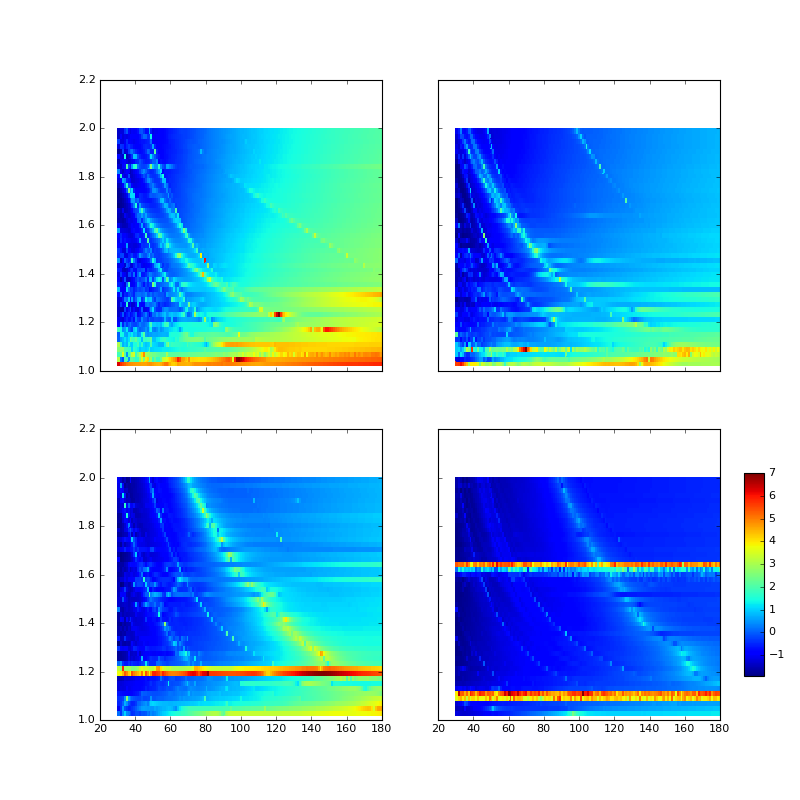

(4, 49, 140)


In [24]:
# resp.pickle came from hornby where I ran TTide.py whoch did the multiprocess to get parallel
resp=pickle.load(open('respkomNew.pickle','rb'))
print resp
kims = np.linspace(0,5e-5,300)
lam = np.linspace(30,250.0,300)*1e3
ks = np.pi*2./lam
lam = np.linspace(40,180.0,100)*1e3
ks = np.pi*2./lam
kims = np.linspace(0,np.pi*2./40e3,100)
oms = np.linspace(1.,2.,50)
oms = oms[1:]
oms = np.linspace(1.,2.,50)
oms = oms[1:]
lam = np.linspace(30,180.0,140)*1e3
ks = np.pi*2./lam

fig,axs=plt.subplots(2,2,sharex=True,sharey=True,figsize=(10,10));axs=axs.flatten()
def format_coord(x, y):
    return 'x=%1.4f, %1.4f, y=%1.4f, %1.4f'%(x,np.pi*2*1e4/(x*1e3),y,np.pi*2/(y))
# resp is returned sorted by ks.  
ks = np.sort(ks)
print np.shape(resp)
for i in range(4):
    R = resp[i]
    lam = np.pi*2./ks
    pcm=axs[i].pcolormesh(lam/1e3,oms,np.log10(R),rasterized=True,cmap='jet')
    #axs[i].set_yscale('log')
    #axs[i].set_ylim([1e-7,5e-5])
    #pcm.set_clim([6.,11.])
    #axs[i].set_xscale('log')
    axs[i].format_coord=format_coord
    #axs[i].set_ylim([0,0.00005])
import jmkfigure
jmkfigure.colorbarRight(pcm,axs[i],fig)
#fig.savefig('ScanNotLow300.pdf')


<IPython.core.display.Javascript object>


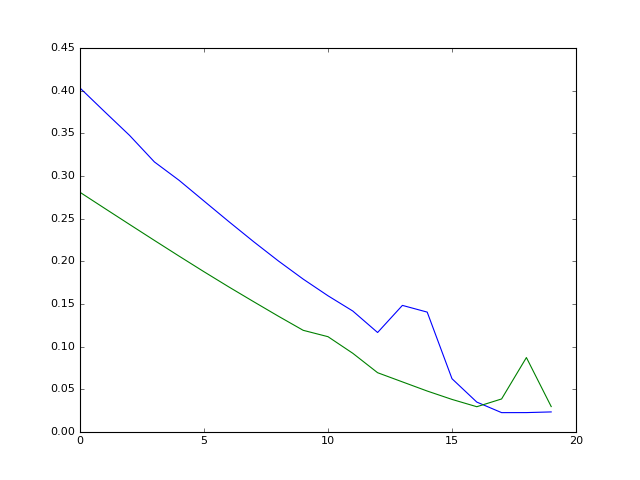

In [23]:
resp=pickle.load(open('respkomTest.pickle','rb'))
fig,ax=plt.subplots()
ax.plot(resp[1][0,:])
ax.plot(resp[1][1,:])

In [ ]:
fig,axs=plt.subplots(1,3)

kks = np.array([90.31e3+1j*243.526e3,153.76e3+1j*1400006.7e3,125e3+1000000.04e3*1j])
kks = np.pi*2./kks
kks[2]=np.real(kks[2])+0*1j

kks[1]=np.real(kks[1])+0*1j


for n,k in enumerate(kks):
    x,z,H,P=SolveRefl(k=k,Nsq0=N0**2,omega=omega+1j*1e-6,f=f,wall=True,x=xmod*1e3,H=Hwkb[1],J=4*32)
    #    k=0.3e-4,Nsq0=2.72e-3**2,omega=1.25*f+1j*1e-6,f=f)
    ZZ = z[:,np.newaxis]*H[np.newaxis,:]
    ax = axs[n]
    pcm=ax.pcolormesh(x/1e3,ZZ,np.real(P),cmap='RdBu_r')
    pcm.set_clim(np.array([-1.,1])*3e12)
    
    ind = np.where(x>12e3)[0]
    res = -1e10
    for num,dt in enumerate(np.linspace(0.,np.pi,100)):
    
        #    k=0.3e-4,Nsq0=2.72e-3**2,omega=1.25*f+1j*1e-6,f=f)
        ind = np.where(x>60e3)[0]
        re=np.mean(np.abs(np.real(P[:,ind]*np.exp(1j*dt)))*H[np.newaxis,ind])
        if re>res:
            res=re
    ax.set_title('%f'%np.log10(res))



In [ ]:
kims = np.linspace(0,np.pi*2./40e3,300)
print np.pi*2./kims/1e3


In [ ]:
fig,axs=plt.subplots()
lam = 2.*np.pi/ks/1e3
#axs.semilogy(lam,respold)

for a in range(4):
    axs.semilogy(lam,resp[a,:],label=todo[a])
axs.legend()
axs.set_xlim(0,350)

#axs.semilogy(lam,resp,'.')

def format_coord(x, y):
    return 'x=%1.4f, %1.4f, y=%1.4f'%(x,np.pi*2*1e4/(x*1e3),y)
axs.format_coord=format_coord

In [ ]:
lamsq=(omega**2-f**2)/(N0**2 - omega**2)
kk = ((0+1)*np.pi/H[0])**2 * lamsq - ks**2
print(kk)
fig,ax=plt.subplots()
ax.plot(2*np.pi/ks*1e-4*10,kk)
ax.grid()

In [ ]:
fig,axs=plt.subplots(1,3)

kks = [0.31, 0.389e-4, .55e-4,]
kks=np.pi*2./np.array([122,123,125])/1e3
for n,k in enumerate(kks):
    x,z,H,P=SolveRefl(k=k,Nsq0=N0**2,omega=omega+1j*1e-6,f=f,wall=True,x=xmod*1e3,H=Hwkb[3],J=4*32)
    #    k=0.3e-4,Nsq0=2.72e-3**2,omega=1.25*f+1j*1e-6,f=f)
    ZZ = z[:,np.newaxis]*H[np.newaxis,:]
    ax = axs[n]
    pcm=ax.pcolormesh(x/1e3,ZZ,np.real(P),cmap='RdBu_r')
    pcm.set_clim(np.array([-1.,1])*3e4)
    
    ind = np.where(x>12e3)[0]
    res = -1e10
    for num,dt in enumerate(np.linspace(0.,np.pi,100)):
    
        #    k=0.3e-4,Nsq0=2.72e-3**2,omega=1.25*f+1j*1e-6,f=f)
        ind = np.where(x>60e3)[0]
        re=np.mean(np.abs(np.real(P[:,ind]*np.exp(1j*dt)))*H[np.newaxis,ind])
        if re>res:
            res=re
    ax.set_title('%f'%np.log10(res))


In [ ]:
print omega/f


In [ ]:
## lets search for some peaks
ks = np.linspace(0.,1.25,150)*1e-4
oms  = np.linspace(1.1,2.,100)
resp = 0.*ks[np.newaxis,:]*oms[:,np.newaxis]
for m,om in enumerate(oms):
    print m
    for n,k in enumerate(ks):
        f=9.3e-5
        x,z,H,P=SolveRefl(k=k,Nsq0=2.72e-3**2,omega=om*f+1j*1e-6,f=f,wall=True)
        ZZ = z[:,np.newaxis]*H[np.newaxis,:]
        Hx = np.gradient(H,x)
        dx = x[1]-x[0]
        dz = z[1]-z[0]
        pp = np.gradient(P,dz,dx)
        u = 1j*(pp[1] - z[:,np.newaxis]/H[np.newaxis,:]*Hx[np.newaxis,:]*pp[0])
        u = u*(-omega/(omega**2-f**2)/1e3)

        ind = np.where(x>12e3)[0]
        resp[m,n]=np.mean(np.abs(P[:,ind])*H[np.newaxis,ind])
        res=1.e-99
        for num,dt in enumerate(np.linspace(0.,np.pi,100)):
            ind = np.where(x>12e3)[0]
            re=np.mean(np.abs(np.real(P[:,ind]*np.exp(1j*dt)))*H[np.newaxis,ind])
            if re>res:
                res=re
        resp[m,n]=res



In [ ]:
fig,axs=plt.subplots(2,1)
ax=axs[0]
#ks = np.linspace(0.,1.05,150)*1e-4
pcm=ax.pcolormesh(ks*1e4,oms,np.log10(resp))
pcm.set_clim([0.,5.])
ax=axs[1]
ind = np.where(oms>=1.5)[0][0]
ax.semilogy(ks*1e4,resp[ind,:])

In [ ]:
fig,axs=plt.subplots(1,5)

f=9.3e-5
kks = [0.24e-4, 0.4e-4, 0.50e-4,0.55e-4,0.65e-4]
for n,k in enumerate(kks):
    x,z,H,P=SolveRefl(k=k,Nsq0=2.72e-3**2,omega=1.5*f+1j*1e-6,f=f,wall=True)
    #    k=0.3e-4,Nsq0=2.72e-3**2,omega=1.25*f+1j*1e-6,f=f)
    ZZ = z[:,np.newaxis]*H[np.newaxis,:]
    ax = axs[n]
    pcm=ax.pcolormesh(x,ZZ,np.abs(P),cmap='RdBu_r')
    pcm.set_clim(np.array([-1.,1])*30e0)
    ind = np.where(x>12e3)[0]
    res = -1e10
    for num,dt in enumerate(np.linspace(0.,np.pi,100)):
    
        #    k=0.3e-4,Nsq0=2.72e-3**2,omega=1.25*f+1j*1e-6,f=f)
        ind = np.where(x>12e3)[0]
        re=np.mean(np.abs(np.real(P[:,ind]*np.exp(1j*dt)))*H[np.newaxis,ind])
        if re>res:
            res=re
    ax.set_title('%f'%np.log10(res))


In [ ]:
fig,axs=plt.subplots()

f=9.3e-5
kks = [0.519e-4]
for n,k in enumerate(kks):
    x,z,H,P=SolveRefl(k=k,Nsq0=2.72e-3**2,omega=1.5*f+1j*1e-6,f=f,wall=True)
    
re = np.zeros(100)
res = -1e10
for num,dt in enumerate(np.linspace(0.,np.pi,100)):
    
    #    k=0.3e-4,Nsq0=2.72e-3**2,omega=1.25*f+1j*1e-6,f=f)
    ind = np.where(x>12e3)[0]
    re=np.mean(np.abs(np.real(P[:,ind]*np.exp(1j*dt)))*H[np.newaxis,ind])
    if re>res:
        res=re
axs.plot(re)
print np.log10(np.max(re))